# 5.3.4 SQL with Spark

In [6]:
!pip install pyspark

     |████████████████████████████████| 317.2 MB 209 bytes/s  0:00:014
     |████████████████████████████████| 200 kB 3.7 MB/s eta 0:00:01
done
  Created wheel for pyspark: filename=pyspark-3.5.5-py2.py3-none-any.whl size=317747881 sha256=562e6ff865fe0be001ca1b431a035b21a52b535154237cb78854d216afe3b1ba
  Stored in directory: /home/cmy/.cache/pip/wheels/9e/5b/b4/a3ac8d456edf8c52eb15f9eb357d961812d5f17bf203c54c18
Successfully built pyspark


In [1]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName('test') \
    .getOrCreate() 

25/03/26 23:00:09 WARN Utils: Your hostname, DESKTOP-BHSOG44 resolves to a loopback address: 127.0.1.1; using 192.168.147.61 instead (on interface eth0)
25/03/26 23:00:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/03/26 23:00:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1: Loading the data
We want to load the green and yellow taxi datasets, which contain taxi trip data for 2020 and 2021. We will use spark.read.parquet since the data is already stored in Parquet format. To load both 2020 and 2021 datasets, we can use a wildcard (*). Since the data has a nested structure (organized by year and month),For example:
（我目前准备的数据中只有2020的data）

In [2]:
df_green = spark.read.parquet('data/pq/green/*/*')

In [3]:
df_yellow = spark.read.parquet('data/pq/yellow/*/*')

## 2: Finding common columns
To unify the data, we will select only the common columns between both datasets.

In [4]:
df_green.columns

['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

In [5]:
df_yellow.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge']

To see what's the common between these two

In [6]:
set(df_green.columns) & set(df_yellow.columns)

{'DOLocationID',
 'PULocationID',
 'RatecodeID',
 'VendorID',
 'congestion_surcharge',
 'extra',
 'fare_amount',
 'improvement_surcharge',
 'mta_tax',
 'passenger_count',
 'payment_type',
 'store_and_fwd_flag',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'trip_distance'}

First, we will rename the pickup and drop-off time columns in each dataset so they match:

In [7]:
df_green = df_green \
    .withColumnRenamed('lpep_pickup_datetime', 'pickup_datetime') \
    .withColumnRenamed('lpep_dropoff_datetime', 'dropoff_datetime')

df_yellow = df_yellow \
    .withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime') \
    .withColumnRenamed('tpep_dropoff_datetime', 'dropoff_datetime')    

Then we will find the common columns and in the same order:

In [8]:
common_colums = []

yellow_columns = set(df_yellow.columns)

for col in df_green.columns:
    if col in yellow_columns:
        common_colums.append(col)

In [9]:
common_colums

['VendorID',
 'pickup_datetime',
 'dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'congestion_surcharge']

## 3: Combining yellow and green data
we will add a new column, service_type, to distinguish records from green and yellow taxi data:

In [10]:
from pyspark.sql import functions as F

In [11]:
df_green_sel = df_green \
    .select(common_colums) \
    .withColumn('service_type', F.lit('green'))


df_yellow_sel = df_yellow \
    .select(common_colums) \
    .withColumn('service_type', F.lit('yellow'))

we can combine both datasets using unionAll:

In [12]:
df_trips_data = df_green_sel.unionAll(df_yellow_sel)

To verify the merge, we can perform a simple groupBy operation:

In [13]:
df_trips_data.groupBy('service_type').count().show()

[Stage 2:===============================================>         (10 + 2) / 12]

+------------+--------+
|service_type|   count|
+------------+--------+
|       green| 1734051|
|      yellow|24648499|
+------------+--------+



## 4: Querying with SQL
Now we can see how to use SQL for querying this data. First, we need to tell Spark that this DataFrame is a table. For that, we use:

In [14]:
df_trips_data.registerTempTable('trips_data')

/home/cmy/spark/spark-3.3.2-bin-hadoop3/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [15]:
df_trips_data.createOrReplaceTempView ('trips_data')

For example, let's count records by service type:

In [16]:
spark.sql("""
SELECT
    service_type,
    count(1)
FROM
    trips_data
GROUP BY 
    service_type
""").show()

[Stage 5:====================================================>    (11 + 1) / 12]

+------------+--------+
|service_type|count(1)|
+------------+--------+
|       green| 1734051|
|      yellow|24648499|
+------------+--------+



Now let's execute this query from module 4:

In [17]:
df_result = spark.sql("""
SELECT 
    -- Reveneue grouping 
    PULocationID AS revenue_zone,
    date_trunc('month', pickup_datetime) AS revenue_month, 
    service_type, 

    -- Revenue calculation 
    SUM(fare_amount) AS revenue_monthly_fare,
    SUM(extra) AS revenue_monthly_extra,
    SUM(mta_tax) AS revenue_monthly_mta_tax,
    SUM(tip_amount) AS revenue_monthly_tip_amount,
    SUM(tolls_amount) AS revenue_monthly_tolls_amount,
    SUM(improvement_surcharge) AS revenue_monthly_improvement_surcharge,
    SUM(total_amount) AS revenue_monthly_total_amount,
    SUM(congestion_surcharge) AS revenue_monthly_congestion_surcharge,

    -- Additional calculations
    AVG(passenger_count) AS avg_montly_passenger_count,
    AVG(trip_distance) AS avg_montly_trip_distance
FROM
    trips_data
GROUP BY
    1, 2, 3
""")

We can show the results with:

In [18]:
df_result \
    .select('revenue_zone', 'revenue_month', 'service_type', 'revenue_monthly_total_amount', 'avg_montly_passenger_count') \
    .show()

[Stage 8:====================================================>    (11 + 1) / 12]

+------------+-------------------+------------+----------------------------+--------------------------+
|revenue_zone|      revenue_month|service_type|revenue_monthly_total_amount|avg_montly_passenger_count|
+------------+-------------------+------------+----------------------------+--------------------------+
|         196|2020-01-01 00:00:00|       green|           62713.79000000236|        1.4023121387283237|
|         184|2020-01-01 00:00:00|       green|           689.6400000000001|                       1.8|
|         263|2020-02-01 00:00:00|       green|           7640.500000000021|        1.4705882352941178|
|         231|2020-02-01 00:00:00|       green|           8635.019999999997|                       1.0|
|         100|2020-02-01 00:00:00|       green|                     1890.41|                      null|
|         252|2020-01-01 00:00:00|       green|           6680.330000000003|                       1.1|
|         258|2020-02-01 00:00:00|       green|          10001.6

## 5: Saving the result
Finally we can save the result:

In [19]:
df_result.coalesce(1).write.parquet('data/report/revenue/', mode='overwrite')

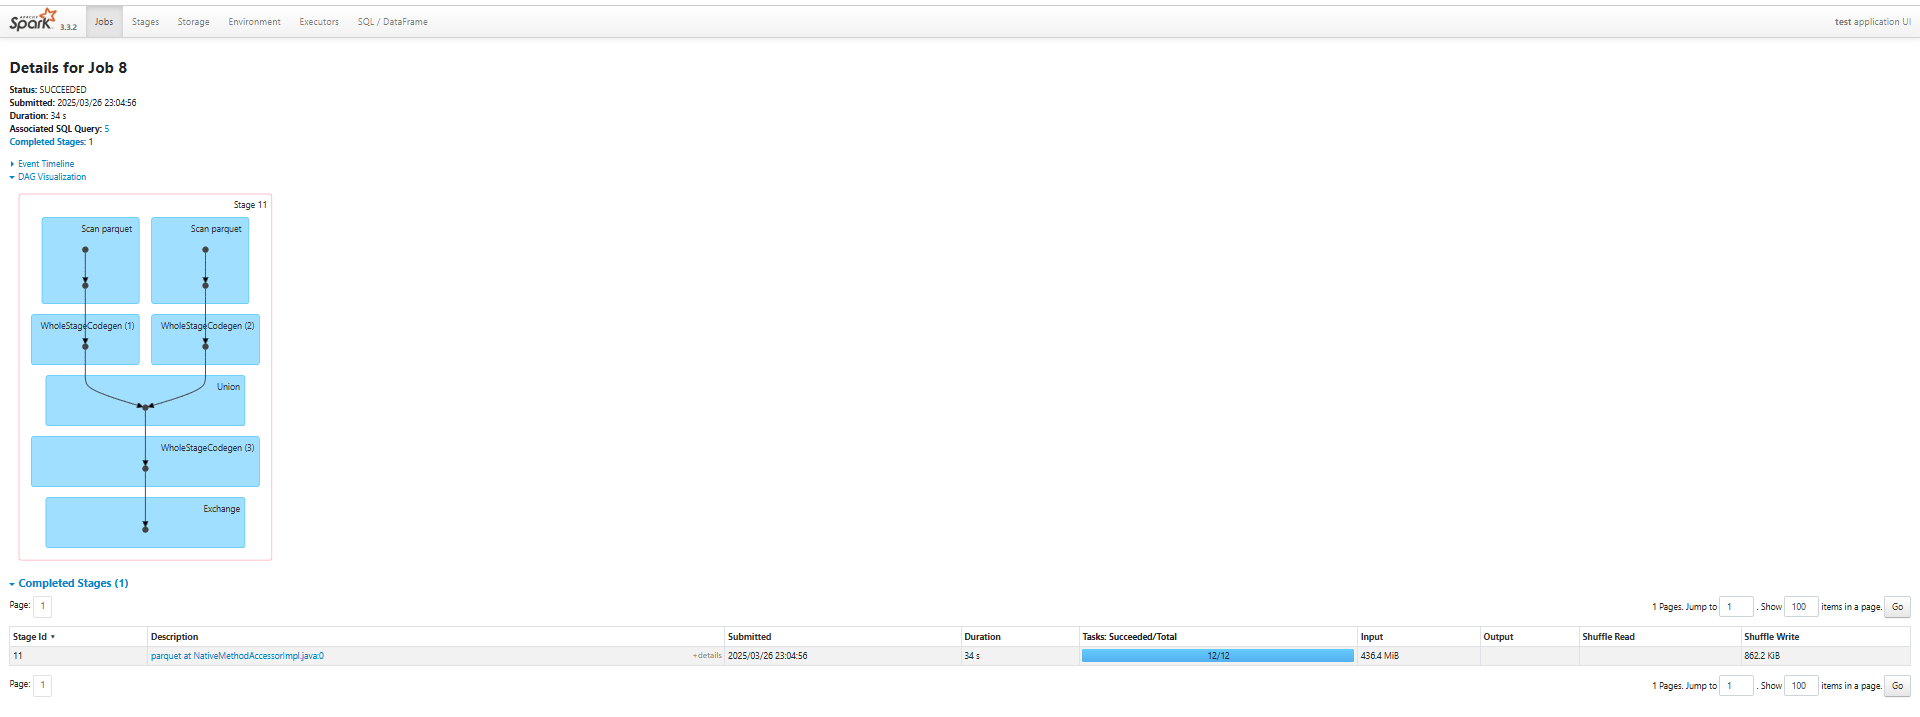